In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
import pingouin as pg
from scipy.stats import levene
from scipy.stats import spearmanr
import scipy.stats as stats

# Data Preparation

In [2]:
df = pd.read_csv('dataset/cleandata_time_ok.csv', delimiter = ',')
print(df.shape)
display(df.head(2))
display(df.info())
display(df.describe())
df['Date-Time'] = pd.to_datetime(df['Date-Time'])
df.set_index('Date-Time', inplace = True)

(3491308, 12)


,Date-Time,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy
0,2021-01-04T09:30:01.673284287,Quote,NaN,NaN,19.0,24.0,19.07,6.0,NaN,2021-01-04,NaN,09:30:01.673284
1,2021-01-04T09:30:01.673284287,Quote,NaN,NaN,19.0,24.0,19.01,6.0,NaN,2021-01-04,NaN,09:30:01.673284


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3491308 entries, 0 to 3491307
Data columns (total 12 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Date-Time           object 
 1   Type                object 
 2   Price               float64
 3   Volume              float64
 4   Bid Price           float64
 5   Bid Size            float64
 6   Ask Price           float64
 7   Ask Size            float64
 8   Tick Dir.           object 
 9   Date                object 
 10  num_tick_direction  float64
 11  Exchange_Time_copy  object 
dtypes: float64(7), object(5)
memory usage: 319.6+ MB


None

,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,num_tick_direction
count,1.377859e+06,1.377859e+06,3.491308e+06,3.491308e+06,3.491308e+06,3.491308e+06,377339.000000
mean,1.872580e+02,9.021554e+01,1.357627e+02,6.963457e+00,1.368762e+02,7.322325e+00,-0.000623
std,1.288883e+02,1.996205e+03,1.228293e+02,4.908565e+01,1.240740e+02,4.234311e+01,1.000001
min,1.710000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000
25%,6.625000e+01,5.000000e+00,3.891000e+01,1.000000e+00,3.903000e+01,1.000000e+00,-1.000000
50%,1.380100e+02,2.500000e+01,7.803000e+01,1.000000e+00,7.850000e+01,1.000000e+00,-1.000000
75%,3.188700e+02,1.000000e+02,2.593300e+02,3.000000e+00,2.630000e+02,3.000000e+00,1.000000
max,4.830000e+02,1.749449e+06,4.808600e+02,4.077000e+03,4.831700e+02,4.143000e+03,1.000000


## Trade Filter and To_Datetime

In [3]:
# Trade is for without resampling, to give insight on the overall period
trade = df[df['Type'] == 'Trade'].copy(deep = True)

# Trade_2 is the one for resampling 1-min and 5-min intervals
trade_2 = df[df['Type'] == 'Trade'].copy(deep = True)

# Trade_3 is for resampling 5-sec intervals
trade_3 = df[df['Type'] == 'Trade'].copy(deep = True)

display(trade.shape)
display(trade_2.shape)
display(trade_3.shape)

# Ensure date-time series
print(type(trade.index[0]))
print(type(trade_2.index[0]))
print(type(trade_3.index[0]))

(1377859, 11)

(1377859, 11)

(1377859, 11)

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [4]:
trade.info()
trade_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1377859 entries, 2021-01-04 09:30:01.676587591 to 2021-01-29 15:59:59.984096412
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Type                1377859 non-null  object 
 1   Price               1377859 non-null  float64
 2   Volume              1377859 non-null  float64
 3   Bid Price           1377859 non-null  float64
 4   Bid Size            1377859 non-null  float64
 5   Ask Price           1377859 non-null  float64
 6   Ask Size            1377859 non-null  float64
 7   Tick Dir.           377339 non-null   object 
 8   Date                1377859 non-null  object 
 9   num_tick_direction  377339 non-null   float64
 10  Exchange_Time_copy  1377859 non-null  object 
dtypes: float64(7), object(4)
memory usage: 126.1+ MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1377859 entries, 2021-01-04 09:30:01.676587591 to 2021-01-29 15:

## Global Charting

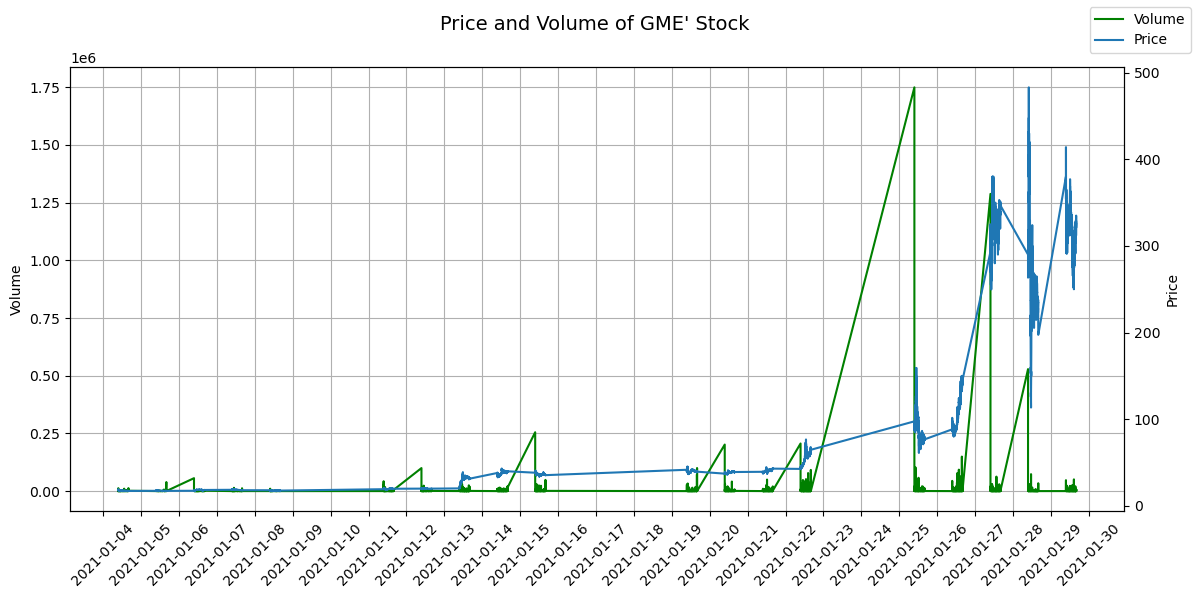

In [5]:
# Chart: Volume
fig = plt.figure(figsize = (12,6))
ax0 = fig.add_subplot(111)
ax0.plot(trade.index, trade['Volume'], 'g', label = 'Volume')
plt.xticks(rotation = 45)
ax0.grid()

# Chart: Price
ax1 = ax0.twinx()
ax1.plot(trade.index, trade['Price'], label = 'Price')

# Ticks, Title, Labels
ax0.xaxis.set_major_locator(mdates.DayLocator())
ax0.set_ylabel('Volume')
ax1.set_ylabel('Price')
fig.legend()
fig.suptitle('Price and Volume of GME\' Stock', fontsize = 14)
plt.tight_layout()

plt.savefig('gme.png', format = 'png')

plt.show()




# Functions and Entire Dataset

## Helper Functions

In [6]:
def trade_cat(df):
    
    '''
    This is my interpretation of the result,
    modified by introducing Micro group and combining the Small subgroups, and Medium subgroups.
    '''
    
    # Trade Categories based on Literature

    # Calculate Volume Classifier L1
    df.loc[(df['Volume'] <= 199), 'Trade_Size_L1'] = 'Micro'
    df.loc[(df['Volume'] > 199) & (df['Volume'] <= 499), 'Trade_Size_L1'] = 'Small'
    df.loc[(df['Volume'] > 499) & (df['Volume'] <= 9999), 'Trade_Size_L1'] = 'Medium'
    df.loc[(df['Volume'] > 9999), 'Trade_Size_L1'] = 'Large'

    # Calculate Volume Classifier L2
    df.loc[df['Volume'] <= 199, 'Trade_Size_L2'] = '<200'
    df.loc[(df['Volume'] > 199 ) & (df['Volume'] <= 299), 'Trade_Size_L2'] = '200-299'
    df.loc[(df['Volume'] > 299 ) & (df['Volume'] <= 399), 'Trade_Size_L2'] = '300-399'
    df.loc[(df['Volume'] > 399 ) & (df['Volume'] <= 499), 'Trade_Size_L2'] = '400-499'
    df.loc[(df['Volume'] > 499) & (df['Volume'] <= 999), 'Trade_Size_L2'] = '500-999'
    df.loc[(df['Volume'] > 999) & (df['Volume'] <= 2999), 'Trade_Size_L2'] = '1000-2999'
    df.loc[(df['Volume'] > 2999) & (df['Volume'] <= 5999), 'Trade_Size_L2'] = '3000-5999'
    df.loc[(df['Volume'] > 5999) & (df['Volume'] <= 9999), 'Trade_Size_L2'] = '6000-9999'
    df.loc[(df['Volume'] > 9999), 'Trade_Size_L2'] = '10000+'
    
    # Previous price
    df['Prev_Price'] = df['Price'].shift(periods = 1).fillna(0)
    
    # Price Change
    df['Price_Change'] = (df['Price'] - df['Prev_Price']).fillna(0)
    df.loc[(df.index == min(df.index)), 'Price_Change'] = 0 # --> 1st row price change is always 0
    
    # Price Change -- Abs Value 
    df['Price_Change_Abs'] = np.abs(df['Price_Change'])
    
    return df

In [7]:
def mqr_prc_c(df):
    '''
    Calculate Mid-Quote Return and Cumulative Price Change
    '''
    # Mid-Quote 
    df['Mid_Quote'] = (df['Bid Price'] + df['Ask Price'])/2
    
    # Previous mid-quote
    df['Prev_Mid_Quote'] = df['Mid_Quote'].shift(periods = 1).fillna(0)
    
    # Next mid-quote
    df['Next_Mid_Quote'] = df['Mid_Quote'].shift(periods = -1).fillna(0)
    
    # Mid-Quote Return
    df['Mid_Quote_Return'] = ((df['Mid_Quote'] - df['Prev_Mid_Quote'])/df['Prev_Mid_Quote']).fillna(0)
        
    #replace inf and -inf with zero
    df.replace([np.inf, -np.inf], 0, inplace = True)
    
    
    return df

In [8]:
def piv_varrat(df):
    '''
    Create pivot table of variance ratio as per literature
    '''   
    
    # Calculate the log return
    to_log = list(np.abs(df['Mid_Quote_Return']))

    logret = []
    for i in to_log:
        if i == 0:
            logret_ = 0
        else:
            logret_ = np.log10(i)
        logret.append(logret_)

    df['Log_Return'] = logret
    
    # Create Pivot Table
    
    piv_varrat = pd.pivot_table(df, index = [df.index.date, 'Trade_Size_L1'],
                                 values = ['Log_Return'], 
                                  aggfunc = np.std, margins = False)

    # Calculate value of Variance
    piv_varrat = piv_varrat.rename(columns = {'Log_Return':'STD_Log_MQR'})


    piv_varrat['Variance'] = (piv_varrat['STD_Log_MQR'] **2)

    
    return piv_varrat
    

In [9]:
def plot_(df, interval, aggr):
    '''
    Can use this in a loop to compare resampling techniques
    '''

    # Value Counts
    display(trade['Trade_Size_L1'].value_counts())
    display(trade['Trade_Size_L2'].value_counts())
    trade_size_l1 = trade['Trade_Size_L1'].unique()

    # Plotting
    fig, ax = plt.subplots(figsize = (12,6))

    ax0 = fig.add_subplot()
    ax0.grid()
    plt.xticks(rotation = 90)

    ax1 = ax0.twinx()
    
    ax0 = sns.lineplot(x = df.index, y = 'Mid_Quote_Return', data = df, hue = 'Trade_Size_L1') #label = 'Mid-Quote Return'
    sns.lineplot(x = df.index, y = 'Price_Change', data = df, hue = 'Trade_Size_L1', ax = ax1, linestyle = '--') #label = 'Price Change'

   
    # Ticks, Title, Labels
    ax0.xaxis.set_major_locator(mdates.DayLocator())
    ax0.set_ylabel('Mid-Quote Return')
    ax1.set_ylabel('Price Change')
 
    fig.suptitle(f'Mid-Quote Return and Price Change by Size {interval} with {aggr} Aggregation', fontsize = 14)
    
    plt.show()

In [10]:
def piv_cumprice(df):
    '''
    Create pivot table as per literature
    '''
    # Create Pivot Table

    piv_cumprice = pd.pivot_table(df, index = ['Trade_Size_L1', 'Trade_Size_L2'],
                                 values = ['Price_Change', 'Price','Volume'], 
                                  aggfunc = {'Price_Change':np.sum,'Price':'count','Volume': np.sum}, margins = False)

    
    piv_cumprice['% Price_Change'] = np.round((piv_cumprice['Price_Change']/piv_cumprice['Price_Change'].sum())*100, 2)
    piv_cumprice['% Trade'] = np.round((piv_cumprice['Price']/piv_cumprice['Price'].sum())*100, 2)
    piv_cumprice['% Volume'] = np.round((piv_cumprice['Volume']/piv_cumprice['Volume'].sum())*100, 2)

    piv_cumprice = piv_cumprice.rename(columns = {'Price':'# of Trade'})

    # Final Pivot Table with sum
    piv_cumprice = pd.pivot_table(piv_cumprice, index = ['Trade_Size_L1', 'Trade_Size_L2'], 
                                  aggfunc = 'sum', margins = 'all')


    

    # Sort index S-M-L
    piv_cumprice = piv_cumprice.sort_index(level = [0, 1], ascending = [False, True]) 
    
    new_order = ['Price_Change', '% Price_Change',
                 '# of Trade', '% Trade', 'Volume', '% Volume']

    piv_cumprice = piv_cumprice.reindex(columns = new_order)

    display(piv_cumprice)
    return piv_cumprice
    

In [11]:
def simple_pi_spread(df):
    '''
    Calculate simple price impact and spreads (proxies for liquidity)
    Must be resampled for 5S interval based on literature
    '''
    # 1. Simple Price Impact
    # create a new column 'TickSB' based on the condition of Ask and Bid Price to Price
    
       
    df.loc[(df['Price'] < df['Mid_Quote']), 'TickSB'] = -1 # Seller initiated
    df.loc[(df['Price'] > df['Mid_Quote']), 'TickSB'] = 1 # Buyer initiated
    
    # Tick Test
    df.loc[(df['Price'] == df['Mid_Quote']) & (df['Prev_Price'] > df['Price']), 'TickSB'] = -1 # Seller initiated
    df.loc[(df['Price'] == df['Mid_Quote']) & (df['Prev_Price'] < df['Price']), 'TickSB'] = 1 # Buyer initiated
    df.loc[(df['Price'] == df['Mid_Quote']) & (df['Price_Change'] == 0), 'TickSB'] = df['num_tick_direction'] # Follow the original one
    
    # Calculate PI
    df['Simple_PI'] = 2 * df['TickSB'] * (df['Next_Mid_Quote'] - df['Mid_Quote'])/df['Mid_Quote']
    
    # 2. Spread
    df['Eff_Spread'] = 2 * df['TickSB'] * (df['Price'] - df['Mid_Quote'])/df['Mid_Quote']
    df['Realised_Spread'] = df['Eff_Spread'] - df['Simple_PI']
    
    return df

In [12]:
# In the resampled dataframes, the max might not be captured because the aggregation function is 'last'

max(trade['Volume'])


1749449.0

## Trade Category

In [13]:
# Trade category

# result = [trade_min_last, trade_h_last, trade_min_mean, trade_h_mean]
# for i in result:
#         i = trade_cat(i)
        
trade_cat(trade)

,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy,Trade_Size_L1,Trade_Size_L2,Prev_Price,Price_Change,Price_Change_Abs
Date-Time,,,,,,,,,,,,,,,,
2021-01-04 09:30:01.676587591,Trade,19.01,25.0,19.0,24.0,19.02,1.0,NaN,2021-01-04,NaN,09:30:01.676587,Micro,<200,0.00,0.00,0.00
2021-01-04 09:30:02.752529040,Trade,19.04,20.0,19.0,24.0,19.06,1.0,NaN,2021-01-04,NaN,09:30:02.752529,Micro,<200,19.01,0.03,0.03
2021-01-04 09:30:03.784980999,Trade,19.05,2.0,19.0,24.0,19.06,1.0,NaN,2021-01-04,NaN,09:30:03.784980,Micro,<200,19.04,0.01,0.01
2021-01-04 09:30:04.792279959,Trade,19.05,49.0,19.0,22.0,19.06,1.0,NaN,2021-01-04,NaN,09:30:04.792279,Micro,<200,19.05,0.00,0.00
2021-01-04 09:30:04.792279959,Trade,19.06,100.0,19.0,22.0,19.06,1.0,^,2021-01-04,1.0,09:30:04.792279,Micro,<200,19.05,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:59:59.875667000,Trade,328.00,15.0,328.0,23.0,328.48,1.0,NaN,2021-01-29,NaN,15:59:59.875667,Micro,<200,328.00,0.00,0.00
2021-01-29 15:59:59.887567967,Trade,328.00,10.0,328.0,23.0,328.48,1.0,NaN,2021-01-29,NaN,15:59:59.887567,Micro,<200,328.00,0.00,0.00
2021-01-29 15:59:59.936339122,Trade,328.00,1.0,328.0,23.0,328.48,1.0,NaN,2021-01-29,NaN,15:59:59.936339,Micro,<200,328.00,0.00,0.00


In [14]:
# Checking unique values of L1, should include Micro

trade['Trade_Size_L1'].unique()

array(['Micro', 'Small', 'Medium', 'Large'], dtype=object)

## Pivot Table

In [15]:
# The Price Change Columns

y = piv_cumprice(trade)
y.to_csv('dataset/pivot_result.csv')
display(type(y))

Price_Change  % Price_Change  # of Trade  \
Trade_Size_L1 Trade_Size_L2                                             
Small         200-299             -80.822          -26.16       55447   
              300-399             -14.720           -4.76       24195   
              400-499             -34.432          -11.14       12974   
Micro         <200                339.952          110.02     1251069   
Medium        1000-2999           -13.405           -4.34        9761   
              3000-5999             2.904            0.94        1571   
              500-999             -21.077           -6.82       22078   
              6000-9999             6.050            1.96         426   
Large         10000+              124.540           40.31         338   
All                               308.990          100.01     1377859   

                             % Trade       Volume  % Volume  
Trade_Size_L1 Trade_Size_L2                                  
Small         200-299           4.02   12008567.0      9.66  
              300-399           1.76    7741896.0      6.23  
              400-499           0.94    5487387.0      4.41  
Micro         <200             90.80   48726265.0     39.20  
Medium        1000-2999         0.71   15007505.0     12.07  
              3000-5999         0.11    6393466.0      5.14  
              500-999           1.60   14319734.0     11.52  
              6000-9999         0.03    3263107.0      2.63  
Large         10000+            0.02   11356370.0      9.14  
All                            99.99  124304297.0    100.00

pandas.core.frame.DataFrame

## Welch's ANOVA for 4 trade-sizes: data all, not only until 27

In [16]:
trade.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1377859 entries, 2021-01-04 09:30:01.676587591 to 2021-01-29 15:59:59.984096412
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Type                1377859 non-null  object 
 1   Price               1377859 non-null  float64
 2   Volume              1377859 non-null  float64
 3   Bid Price           1377859 non-null  float64
 4   Bid Size            1377859 non-null  float64
 5   Ask Price           1377859 non-null  float64
 6   Ask Size            1377859 non-null  float64
 7   Tick Dir.           377339 non-null   object 
 8   Date                1377859 non-null  object 
 9   num_tick_direction  377339 non-null   float64
 10  Exchange_Time_copy  1377859 non-null  object 
 11  Trade_Size_L1       1377859 non-null  object 
 12  Trade_Size_L2       1377859 non-null  object 
 13  Prev_Price          1377859 non-null  float64
 14  Price_Change 

In [17]:
# Test Variances between Samples using Levene
micro_dependent = trade[trade['Trade_Size_L1'] == 'Micro']['Price_Change']
small_dependent = trade[trade['Trade_Size_L1'] == 'Small']['Price_Change']
med_dependent = trade[trade['Trade_Size_L1'] == 'Medium']['Price_Change']
large_dependent = trade[trade['Trade_Size_L1'] == 'Large']['Price_Change']
print(micro_dependent.shape)
print(small_dependent.shape)
print(med_dependent.shape)
print(large_dependent.shape)

stat, p = levene(micro_dependent, small_dependent, med_dependent, large_dependent, center = 'median')
display(stat, p)
print(f'p < 0.05', p < 0.05)
print(f'p-value = {p}, which means statistically significant --> populations don\'t have equal variances.')

(1251069,)
(92616,)
(33836,)
(338,)


2085.7271395861935

0.0

p < 0.05 True
p-value = 0.0, which means statistically significant --> populations don't have equal variances.


In [18]:
# Perform Welch's test between Micro and the other groups

tstat1, pval1 = stats.ttest_ind(micro_dependent, small_dependent, equal_var = False)
tstat2, pval2 = stats.ttest_ind(micro_dependent, med_dependent, equal_var = False)
tstat3, pval3 = stats.ttest_ind(micro_dependent, large_dependent, equal_var = False)
tstatval = [tstat1, tstat2, tstat3]
pvalval = [pval1, pval2, pval3]
index_cat = ['Micro-Small', 'Micro-Medium', 'Micro-Large']

welch_tab = pd.DataFrame({'t-statistic':tstatval, 'p-value': pvalval}, index = index_cat)
display(welch_tab)
welch_tab.to_csv('welch_tab.csv')

,t-statistic,p-value
Micro-Small,2.986812,0.002819
Micro-Medium,1.307163,0.191163
Micro-Large,-0.768023,0.443011


In [19]:
# Perform Welch's ANOVA to compare the means of the 4 trade groups
aov = pg.welch_anova(dv = 'Price_Change', between = 'Trade_Size_L1', data = trade)

# p-val is not statistically significant --> deliberation
display(aov)
aov.to_csv('aov.csv')

,Source,ddof1,ddof2,F,p-unc,np2
0,Trade_Size_L1,3,1669.196835,3.282498,0.020146,0.000231


In [20]:
gh = pg.pairwise_gameshowell(dv = 'Price_Change', between = 'Trade_Size_L1', data = trade)
gh.to_csv('gh.csv')

# 1-min and 5-min Dataframes

In [21]:
# Flow: Split df into each day subdf, resample each subdf for 1H and 1min.
# Do SML Var Ratio
# Output Table:
'''
Date | L1 | Var 1min | Var 5min | Var Ratio

then plot for the entire period


'''

'\nDate | L1 | Var 1min | Var 5min | Var Ratio\n\nthen plot for the entire period\n\n\n'

## Initial Descriptive

In [22]:
# Start Fresh with Trade 2

# Loop the df name
dates = np.unique(trade_2.index.day)

# A. 1-min INTERVAL
# ================
dfname_list_1min = []
for i in dates:
    dfname = 'df_' + str(i)
    dfname_list_1min.append(dfname)
print(dfname_list_1min)

# Resample each date's df
           
for i in range(len(dfname_list_1min)):
    
    df = trade_2[trade_2.index.day == dates[i]]
    
    dfname_list_1min[i] = df.resample('T').last().interpolate(method = 'linear')
    dfname_list_1min[i] = trade_cat(dfname_list_1min[i])
    dfname_list_1min[i] = mqr_prc_c(dfname_list_1min[i])
    
    # Dropping the 1st row because of 0
    dfname_list_1min[i] = dfname_list_1min[i].iloc[1:, :]
    
# Concatenate

trade_1_min = pd.DataFrame()

for i in range(len(dfname_list_1min)):
    trade_1_min = pd.concat([trade_1_min, dfname_list_1min[i]])

display(trade_1_min)
print(trade_1_min.shape)

# B. 5-min INTERVAL
# ================

dfname_list_5min = []
for i in dates:
    dfname = 'df_' + str(i)
    dfname_list_5min.append(dfname)
print(dfname_list_5min)

# Resample each date's df
           
for i in range(len(dfname_list_5min)):
    
    df = trade_2[trade_2.index.day == dates[i]]
    
    dfname_list_5min[i] = df.resample('5T').last().interpolate(method = 'linear')
    dfname_list_5min[i] = trade_cat(dfname_list_5min[i])
    dfname_list_5min[i] = mqr_prc_c(dfname_list_5min[i])
    dfname_list_5min[i] = dfname_list_5min[i].iloc[1:, :]
    
# Concatenate

trade_5_min = pd.DataFrame()

for i in range(len(dfname_list_5min)):
    trade_5_min = pd.concat([trade_5_min, dfname_list_5min[i]])

display(trade_5_min)
print(trade_5_min.shape)

['df_4', 'df_5', 'df_6', 'df_7', 'df_8', 'df_11', 'df_12', 'df_13', 'df_14', 'df_15', 'df_19', 'df_20', 'df_21', 'df_22', 'df_25', 'df_26', 'df_27', 'df_28', 'df_29']


,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy,Trade_Size_L1,Trade_Size_L2,Prev_Price,Price_Change,Price_Change_Abs,Mid_Quote,Prev_Mid_Quote,Next_Mid_Quote,Mid_Quote_Return
Date-Time,,,,,,,,,,,,,,,,,,,,
2021-01-04 09:31:00,Trade,18.98,55.0,18.95,1.0,19.02,2.0,v,2021-01-04,-1.0,09:31:56.932246,Micro,<200,19.03,-0.05,0.05,18.985,19.025,18.945,-0.002102
2021-01-04 09:32:00,Trade,18.96,85.0,18.92,1.0,18.97,1.0,^,2021-01-04,1.0,09:32:57.889233,Micro,<200,18.98,-0.02,0.02,18.945,18.985,18.815,-0.002107
2021-01-04 09:33:00,Trade,18.79,1050.0,18.79,10.0,18.84,2.0,v,2021-01-04,-1.0,09:33:49.305081,Medium,1000-2999,18.96,-0.17,0.17,18.815,18.945,18.680,-0.006862
2021-01-04 09:34:00,Trade,18.66,20.0,18.65,9.0,18.71,3.0,v,2021-01-04,-1.0,09:34:51.448805,Micro,<200,18.79,-0.13,0.13,18.680,18.815,18.475,-0.007175
2021-01-04 09:35:00,Trade,18.49,1.0,18.43,3.0,18.52,1.0,^,2021-01-04,1.0,09:35:46.600386,Micro,<200,18.66,-0.17,0.17,18.475,18.680,18.280,-0.010974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:55:00,Trade,317.36,28.0,316.62,1.0,319.00,3.0,^,2021-01-29,1.0,15:55:59.675959,Micro,<200,325.74,-8.38,8.38,317.810,325.395,321.470,-0.023310
2021-01-29 15:56:00,Trade,321.00,1.0,320.95,2.0,321.99,2.0,^,2021-01-29,1.0,15:56:59.416251,Micro,<200,317.36,3.64,3.64,321.470,317.810,327.500,0.011516
2021-01-29 15:57:00,Trade,327.04,1.0,327.00,16.0,328.00,23.0,v,2021-01-29,-1.0,15:57:59.987839,Micro,<200,321.00,6.04,6.04,327.500,321.470,328.590,0.018758


(7375, 20)
['df_4', 'df_5', 'df_6', 'df_7', 'df_8', 'df_11', 'df_12', 'df_13', 'df_14', 'df_15', 'df_19', 'df_20', 'df_21', 'df_22', 'df_25', 'df_26', 'df_27', 'df_28', 'df_29']


,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy,Trade_Size_L1,Trade_Size_L2,Prev_Price,Price_Change,Price_Change_Abs,Mid_Quote,Prev_Mid_Quote,Next_Mid_Quote,Mid_Quote_Return
Date-Time,,,,,,,,,,,,,,,,,,,,
2021-01-04 09:35:00,Trade,18.20,157.0,18.18,7.0,18.26,1.0,v,2021-01-04,-1.0,09:39:52.040686,Micro,<200,18.66,-0.46,0.46,18.220,18.680,18.150,-0.024625
2021-01-04 09:40:00,Trade,18.16,50.0,18.09,1.0,18.21,1.0,^,2021-01-04,1.0,09:44:40.892317,Micro,<200,18.20,-0.04,0.04,18.150,18.220,17.950,-0.003842
2021-01-04 09:45:00,Trade,17.95,10.0,17.92,2.0,17.98,1.0,^,2021-01-04,1.0,09:49:57.901054,Micro,<200,18.16,-0.21,0.21,17.950,18.150,17.580,-0.011019
2021-01-04 09:50:00,Trade,17.57,47.0,17.56,6.0,17.60,1.0,^,2021-01-04,1.0,09:54:53.488966,Micro,<200,17.95,-0.38,0.38,17.580,17.950,17.430,-0.020613
2021-01-04 09:55:00,Trade,17.44,100.0,17.40,8.0,17.46,1.0,^,2021-01-04,1.0,09:59:56.064212,Micro,<200,17.57,-0.13,0.13,17.430,17.580,17.295,-0.008532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:35:00,Trade,312.01,10.0,311.07,1.0,314.99,2.0,v,2021-01-29,-1.0,15:39:59.416133,Micro,<200,313.00,-0.99,0.99,313.030,313.000,319.215,0.000096
2021-01-29 15:40:00,Trade,319.23,30.0,318.53,1.0,319.90,4.0,^,2021-01-29,1.0,15:44:59.843839,Micro,<200,312.01,7.22,7.22,319.215,313.030,326.980,0.019758
2021-01-29 15:45:00,Trade,328.19,8.0,325.02,2.0,328.94,1.0,^,2021-01-29,1.0,15:49:59.880323,Micro,<200,319.23,8.96,8.96,326.980,319.215,325.395,0.024325


(1461, 20)


In [23]:
# Test to check NaN after resampling

nullval = trade_5_min['Price'].isna().sum()

print(nullval)

display(trade_5_min[trade_5_min['Price'].isna()]) # --> fine because not in the numbers

0


,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy,Trade_Size_L1,Trade_Size_L2,Prev_Price,Price_Change,Price_Change_Abs,Mid_Quote,Prev_Mid_Quote,Next_Mid_Quote,Mid_Quote_Return
Date-Time,,,,,,,,,,,,,,,,,,,,


## Variance Ratio

In [24]:
# Checking unique values because if there's only 1 entry, cannot calculate std - var

print('Trade_1_min unique value counts:\n', trade_1_min['Trade_Size_L1'].value_counts())
print('Trade_5_min unique value counts:\n', trade_5_min['Trade_Size_L1'].value_counts())

#--> from the result, exclude 'Large' from the variance ratio calc

Trade_1_min unique value counts:
 Micro     6250
Small      883
Medium     241
Large        1
Name: Trade_Size_L1, dtype: int64
Trade_5_min unique value counts:
 Micro     1241
Small      178
Medium      41
Large        1
Name: Trade_Size_L1, dtype: int64


In [25]:
trade_1_min.describe()

,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,num_tick_direction,Prev_Price,Price_Change,Price_Change_Abs,Mid_Quote,Prev_Mid_Quote,Next_Mid_Quote,Mid_Quote_Return
count,7375.000000,7375.000000,7375.000000,7375.000000,7375.000000,7375.000000,7375.000000,7375.000000,7375.000000,7375.000000,7375.000000,7375.000000,7375.000000,7375.000000
mean,79.004963,116.476678,78.742660,4.262983,79.285195,6.040814,-0.001356,79.012385,-0.007422,0.998331,79.013927,79.020628,78.802495,0.000179
std,101.003820,316.028834,100.563457,13.729201,101.483491,27.596576,0.990894,101.036579,2.977858,2.805511,101.022804,101.054339,100.947651,0.013532
min,17.110000,1.000000,17.100000,1.000000,17.150000,1.000000,-1.000000,17.110000,-42.290000,0.000000,17.130000,17.130000,0.000000,-0.167244
25%,18.890000,19.000000,18.870000,1.000000,18.910000,1.000000,-1.000000,18.890000,-0.090000,0.020500,18.890000,18.890000,18.875000,-0.002456
50%,37.650000,100.000000,37.610000,2.000000,37.710000,2.000000,0.000000,37.650000,0.000000,0.100000,37.645000,37.645000,37.620000,0.000000
75%,75.300000,100.000000,75.055000,3.000000,75.570000,3.000000,1.000000,75.300000,0.120000,0.530000,75.367500,75.367500,74.557500,0.002991
max,468.890000,15000.000000,468.000000,273.000000,469.000000,745.000000,1.000000,468.890000,35.480000,42.290000,468.500000,468.500000,468.500000,0.189709


In [26]:
# Assigning variable names for variance ratio study

# Trade_1_min

trade_1_min_varrat_df = []
trade_5_min_varrat_df = []

for i in ['Micro','Small', 'Medium']:
    trade_1_min_varrat = piv_varrat(trade_1_min[trade_1_min['Trade_Size_L1'] == i].copy(deep = True))
    trade_1_min_varrat_df.append(trade_1_min_varrat)
    
    trade_5_min_varrat = piv_varrat(trade_5_min[trade_5_min['Trade_Size_L1'] == i].copy(deep = True))
    trade_5_min_varrat_df.append(trade_5_min_varrat)
    
# Test
display(trade_1_min_varrat_df[0])
display(trade_5_min_varrat_df[2])


,,STD_Log_MQR,Variance
,Trade_Size_L1,,
2021-01-04,Micro,1.130385,1.277770
2021-01-05,Micro,0.936070,0.876227
2021-01-06,Micro,1.096838,1.203054
2021-01-07,Micro,1.093658,1.196088
2021-01-08,Micro,0.776046,0.602247
2021-01-11,Micro,1.274243,1.623694
2021-01-12,Micro,1.151290,1.325469
2021-01-13,Micro,0.534079,0.285241
2021-01-14,Micro,0.533949,0.285102


,,STD_Log_MQR,Variance
,Trade_Size_L1,,
2021-01-04,Medium,1.361649,1.854087
2021-01-06,Medium,0.211943,0.044920
2021-01-07,Medium,0.598328,0.357996
2021-01-11,Medium,0.485265,0.235482
2021-01-13,Medium,0.560411,0.314061
2021-01-14,Medium,0.170515,0.029076
2021-01-15,Medium,0.397287,0.157837
2021-01-19,Medium,0.087305,0.007622
2021-01-20,Medium,0.354927,0.125973


In [27]:
# Inner Join based on Trade L1 -- different size different list

inner_join_df = []

for i in range(len(trade_1_min_varrat_df)): # --> contains 3 df of micro, small, medium
    index0_ = trade_1_min_varrat_df[i].index.names[0]
    index1_ = trade_1_min_varrat_df[i].index.names[1]
    
    # Inner Join and Rename Columns 
    in_join = pd.merge(trade_1_min_varrat_df[i], trade_5_min_varrat_df[i], on = [index0_, index1_], how = 'inner').rename(columns = {'STD_Log_MQR_x':'STD_Log_MQR_1', 
                                                                                                                                     'Variance_x':'Var_of_Log_MQR_1',
                                               'STD_Log_MQR_y':'STD_Log_MQR_5', 'Variance_y':'Var_of_Log_MQR_5'
                                               })
    
    # Variance Ratio calculation
    in_join['Var_Rat'] = np.abs((in_join['Var_of_Log_MQR_5']/(5 * in_join['Var_of_Log_MQR_1'])) - 1)
    
    inner_join_df.append(in_join)  

# Test
display(max(inner_join_df[0]['Var_Rat']), min(inner_join_df[0]['Var_Rat']))
display(max(inner_join_df[1]['Var_Rat']), min(inner_join_df[1]['Var_Rat']))
display(max(inner_join_df[2]['Var_Rat']), min(inner_join_df[2]['Var_Rat']))
display(inner_join_df[2])

# Twin axes because Medium Variance Ratio skews the observation

0.9529146017284275

0.04241529135966737

0.9904587035476522

0.4011802659314676

0.9909033056342617

0.5797580906132621

,key_0,STD_Log_MQR_1,Var_of_Log_MQR_1,STD_Log_MQR_5,Var_of_Log_MQR_5,Var_Rat
Trade_Size_L1,,,,,,
Medium,"(2021-01-04, Medium)",0.939356,0.882390,1.361649,1.854087,0.579758
Medium,"(2021-01-06, Medium)",0.445514,0.198483,0.211943,0.044920,0.954737
Medium,"(2021-01-07, Medium)",0.877185,0.769453,0.598328,0.357996,0.906948
Medium,"(2021-01-11, Medium)",0.442375,0.195696,0.485265,0.235482,0.759339
Medium,"(2021-01-13, Medium)",0.408172,0.166604,0.560411,0.314061,0.622985
Medium,"(2021-01-14, Medium)",0.522447,0.272951,0.170515,0.029076,0.978695
Medium,"(2021-01-15, Medium)",0.435824,0.189942,0.397287,0.157837,0.833805
Medium,"(2021-01-19, Medium)",0.409368,0.167582,0.087305,0.007622,0.990903
Medium,"(2021-01-20, Medium)",0.441095,0.194565,0.354927,0.125973,0.870508


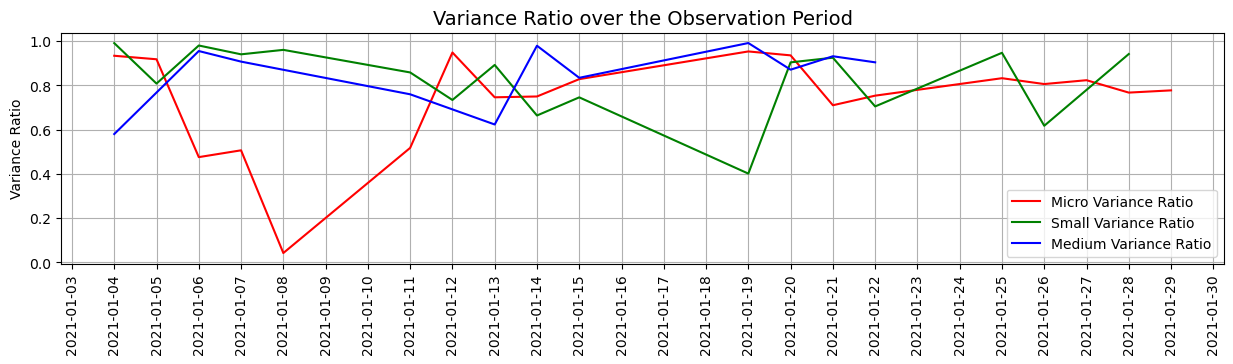

In [28]:
# Plotting the Variance Ratio among 3 trade sizes


# Index for plots Micro, Small, Medium

list_x_index = []

for i in inner_join_df:
    
    list_x = list(i['key_0'])
    index_date_ = []
    for j in list_x:
        date_a = j[0]
        index_date_.append(date_a)
    list_x_index.append(index_date_)

# print(list_x_index)

# Set x and y
index_mic = list_x_index[0]
index_s = list_x_index[1]
index_med = list_x_index[2]

var_rat_mic = inner_join_df[0]['Var_Rat']
var_rat_s = inner_join_df[1]['Var_Rat']
var_rat_med = inner_join_df[2]['Var_Rat']

# Plotting
fig, ax0 = plt.subplots(figsize = (15,3))
ax0.plot(index_mic, var_rat_mic, 'r-', label = 'Micro Variance Ratio')
ax0.plot(index_s, var_rat_s, 'g-', label = 'Small Variance Ratio')
ax0.plot(index_med, var_rat_med, 'b-', label = 'Medium Variance Ratio')
plt.xticks(rotation = 90)



ax0.legend(loc = 'lower right')


# Ticks, Title, Labels
ax0.xaxis.set_major_locator(mdates.DayLocator())
ax0.set_ylabel('Variance Ratio')


plt.grid()
plt.title('Variance Ratio over the Observation Period', fontsize = 14)
plt.show()


# 5-sec Dataframe for Simple PI, Spread

For calculating simple price impact and spread, the data must be resampled in 5s interval as per literature.

## Resample 5-s

In [29]:
trade_3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1377859 entries, 2021-01-04 09:30:01.676587591 to 2021-01-29 15:59:59.984096412
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Type                1377859 non-null  object 
 1   Price               1377859 non-null  float64
 2   Volume              1377859 non-null  float64
 3   Bid Price           1377859 non-null  float64
 4   Bid Size            1377859 non-null  float64
 5   Ask Price           1377859 non-null  float64
 6   Ask Size            1377859 non-null  float64
 7   Tick Dir.           377339 non-null   object 
 8   Date                1377859 non-null  object 
 9   num_tick_direction  377339 non-null   float64
 10  Exchange_Time_copy  1377859 non-null  object 
dtypes: float64(7), object(4)
memory usage: 126.1+ MB


In [30]:
# Start Fresh with Trade 3

# Loop the df name
dates = np.unique(trade_3.index.day)

# # Dictionary of columns and interpolation methods
# interp = {'Price': 'linear', 'Volume': 'linear', 'Bid Price': 'linear', 'Bid Size': 'linear',
#          'Ask Price' : 'linear', 'Ask Size':'linear'}

# A. 5-s INTERVAL
# ================
dfname_list_5s = []
for i in dates:
    dfname = 'df_' + str(i)
    dfname_list_5s.append(dfname)
print(dfname_list_5s)

# Resample each date's df
           
for i in range(len(dfname_list_5s)):
    
    df = trade_3[trade_3.index.day == dates[i]]
    
    dfname_list_5s[i] = df.resample('5S').last().ffill()
    dfname_list_5s[i] = trade_cat(dfname_list_5s[i])
    dfname_list_5s[i] = mqr_prc_c(dfname_list_5s[i])
    
    # Dropping the 1st row because of 0
    dfname_list_5s[i] = dfname_list_5s[i].iloc[1:, :]

# Concatenate

trade_5_s = pd.DataFrame()

for i in range(len(dfname_list_5s)):
    trade_5_s = pd.concat([trade_5_s, dfname_list_5s[i]])

display(trade_5_s)
print(trade_5_s.shape)


['df_4', 'df_5', 'df_6', 'df_7', 'df_8', 'df_11', 'df_12', 'df_13', 'df_14', 'df_15', 'df_19', 'df_20', 'df_21', 'df_22', 'df_25', 'df_26', 'df_27', 'df_28', 'df_29']


,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy,Trade_Size_L1,Trade_Size_L2,Prev_Price,Price_Change,Price_Change_Abs,Mid_Quote,Prev_Mid_Quote,Next_Mid_Quote,Mid_Quote_Return
Date-Time,,,,,,,,,,,,,,,,,,,,
2021-01-04 09:30:05,Trade,19.10,85.0,19.04,2.0,19.10,1.0,^,2021-01-04,1.0,09:30:06.896485,Micro,<200,19.06,0.04,0.04,19.070,19.030,19.070,0.002102
2021-01-04 09:30:10,Trade,19.10,85.0,19.04,2.0,19.10,1.0,^,2021-01-04,1.0,09:30:06.896485,Micro,<200,19.10,0.00,0.00,19.070,19.070,19.045,0.000000
2021-01-04 09:30:15,Trade,19.06,100.0,19.00,23.0,19.09,1.0,^,2021-01-04,1.0,09:30:16.900475,Micro,<200,19.10,-0.04,0.04,19.045,19.070,19.045,-0.001311
2021-01-04 09:30:20,Trade,19.06,100.0,19.00,23.0,19.09,1.0,^,2021-01-04,1.0,09:30:16.900475,Micro,<200,19.06,0.00,0.00,19.045,19.045,19.045,0.000000
2021-01-04 09:30:25,Trade,19.06,100.0,19.00,23.0,19.09,1.0,^,2021-01-04,1.0,09:30:16.900475,Micro,<200,19.06,0.00,0.00,19.045,19.045,19.035,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:59:35,Trade,328.01,17.0,328.00,50.0,328.47,1.0,v,2021-01-29,-1.0,15:59:39.992096,Micro,<200,328.39,-0.38,0.38,328.235,328.275,328.705,-0.000122
2021-01-29 15:59:40,Trade,328.75,70.0,328.47,7.0,328.94,1.0,v,2021-01-29,-1.0,15:59:44.984080,Micro,<200,328.01,0.74,0.74,328.705,328.235,328.495,0.001432
2021-01-29 15:59:45,Trade,328.49,1.0,328.49,6.0,328.50,2.0,^,2021-01-29,1.0,15:59:49.976162,Micro,<200,328.75,-0.26,0.26,328.495,328.705,328.350,-0.000639


(88670, 20)


In [31]:
trade_5_s.isna().sum()

Type                  0
Price                 0
Volume                0
Bid Price             0
Bid Size              0
Ask Price             0
Ask Size              0
Tick Dir.             0
Date                  0
num_tick_direction    0
Exchange_Time_copy    0
Trade_Size_L1         0
Trade_Size_L2         0
Prev_Price            0
Price_Change          0
Price_Change_Abs      0
Mid_Quote             0
Prev_Mid_Quote        0
Next_Mid_Quote        0
Mid_Quote_Return      0
dtype: int64

## Simple Price Impact and Spread

In [32]:
simple_pi_spread(trade_5_s)

,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,...,Price_Change,Price_Change_Abs,Mid_Quote,Prev_Mid_Quote,Next_Mid_Quote,Mid_Quote_Return,TickSB,Simple_PI,Eff_Spread,Realised_Spread
Date-Time,,,,,,,,,,,,,,,,,,,,,
2021-01-04 09:30:05,Trade,19.10,85.0,19.04,2.0,19.10,1.0,^,2021-01-04,1.0,...,0.04,0.04,19.070,19.030,19.070,0.002102,1.0,0.000000,0.003146,0.003146
2021-01-04 09:30:10,Trade,19.10,85.0,19.04,2.0,19.10,1.0,^,2021-01-04,1.0,...,0.00,0.00,19.070,19.070,19.045,0.000000,1.0,-0.002622,0.003146,0.005768
2021-01-04 09:30:15,Trade,19.06,100.0,19.00,23.0,19.09,1.0,^,2021-01-04,1.0,...,-0.04,0.04,19.045,19.070,19.045,-0.001311,1.0,0.000000,0.001575,0.001575
2021-01-04 09:30:20,Trade,19.06,100.0,19.00,23.0,19.09,1.0,^,2021-01-04,1.0,...,0.00,0.00,19.045,19.045,19.045,0.000000,1.0,0.000000,0.001575,0.001575
2021-01-04 09:30:25,Trade,19.06,100.0,19.00,23.0,19.09,1.0,^,2021-01-04,1.0,...,0.00,0.00,19.045,19.045,19.035,0.000000,1.0,-0.001050,0.001575,0.002625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:59:35,Trade,328.01,17.0,328.00,50.0,328.47,1.0,v,2021-01-29,-1.0,...,-0.38,0.38,328.235,328.275,328.705,-0.000122,-1.0,-0.002864,0.001371,0.004235
2021-01-29 15:59:40,Trade,328.75,70.0,328.47,7.0,328.94,1.0,v,2021-01-29,-1.0,...,0.74,0.74,328.705,328.235,328.495,0.001432,1.0,-0.001278,0.000274,0.001552
2021-01-29 15:59:45,Trade,328.49,1.0,328.49,6.0,328.50,2.0,^,2021-01-29,1.0,...,-0.26,0.26,328.495,328.705,328.350,-0.000639,-1.0,0.000883,0.000030,-0.000852


In [33]:
display(trade_5_s[trade_5_s.index.day == 19][['Prev_Price', 'Price_Change']])
# Proof that the 1st row Price Change is != 0 because 1st row already dropped

,Prev_Price,Price_Change
Date-Time,,
2021-01-19 09:30:15,41.55,0.15
2021-01-19 09:30:20,41.70,-0.18
2021-01-19 09:30:25,41.52,-0.05
2021-01-19 09:30:30,41.47,0.02
2021-01-19 09:30:35,41.49,-0.65
...,...,...
2021-01-19 15:59:35,39.48,0.02
2021-01-19 15:59:40,39.50,0.01
2021-01-19 15:59:45,39.51,0.00


In [34]:
display(trade_5_s['TickSB'].value_counts())
display(trade_5_s['TickSB'].isna().sum())

-1.0    44987
 1.0    43683
Name: TickSB, dtype: int64

0

## Data Prep for num_tick_dir == 0

In [35]:
# Found isna values of PI due to NA tick

tick_0 = trade_5_s.loc[trade_5_s['TickSB'] == 0, ['Mid_Quote', 'Price', 'Prev_Price', 'Price_Change','TickSB', 'num_tick_direction']]
display(tick_0.shape)
tick_abs_0 = tick_0[(tick_0['num_tick_direction'].isna()) | (tick_0['num_tick_direction'] == 0)]
display(tick_abs_0.shape)

# Based on original data, the num_tick_direction here = NaN. Must do data prep so it's not 0. --> Done in previous cells.

(0, 6)

(0, 6)

In [36]:
display(trade_5_s[['Price', 'Prev_Price', 'Mid_Quote', 'Simple_PI','TickSB']])

,Price,Prev_Price,Mid_Quote,Simple_PI,TickSB
Date-Time,,,,,
2021-01-04 09:30:05,19.10,19.06,19.070,0.000000,1.0
2021-01-04 09:30:10,19.10,19.10,19.070,-0.002622,1.0
2021-01-04 09:30:15,19.06,19.10,19.045,0.000000,1.0
2021-01-04 09:30:20,19.06,19.06,19.045,0.000000,1.0
2021-01-04 09:30:25,19.06,19.06,19.045,-0.001050,1.0
...,...,...,...,...,...
2021-01-29 15:59:35,328.01,328.39,328.235,-0.002864,-1.0
2021-01-29 15:59:40,328.75,328.01,328.705,-0.001278,1.0
2021-01-29 15:59:45,328.49,328.75,328.495,0.000883,-1.0


In [37]:
trade_5_s.loc[trade_5_s['Simple_PI'] == min(trade_5_s['Simple_PI'])]

,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,...,Price_Change,Price_Change_Abs,Mid_Quote,Prev_Mid_Quote,Next_Mid_Quote,Mid_Quote_Return,TickSB,Simple_PI,Eff_Spread,Realised_Spread
Date-Time,,,,,,,,,,,,,,,,,,,,,
2021-01-06 15:59:55,Trade,18.39,1675.0,18.38,51.0,18.39,66.0,v,2021-01-06,-1.0,...,0.000,0.000,18.385,18.390,0.0,-0.000272,1.0,-2.0,5.439217e-04,2.000544
2021-01-07 15:59:55,Trade,18.12,100.0,18.07,273.0,18.12,27.0,^,2021-01-07,1.0,...,0.070,0.070,18.095,18.060,0.0,0.001938,1.0,-2.0,2.763194e-03,2.002763
2021-01-08 15:59:55,Trade,17.69,1.0,17.68,19.0,17.69,78.0,v,2021-01-08,-1.0,...,0.000,0.000,17.685,17.695,0.0,-0.000565,1.0,-2.0,5.654509e-04,2.000565
2021-01-11 15:59:55,Trade,19.93,5900.0,19.92,64.0,19.93,37.0,^,2021-01-11,1.0,...,0.005,0.005,19.925,19.925,0.0,0.000000,1.0,-2.0,5.018821e-04,2.000502
2021-01-12 15:59:55,Trade,19.94,700.0,19.93,11.0,19.95,253.0,^,2021-01-12,1.0,...,0.000,0.000,19.940,19.935,0.0,0.000251,1.0,-2.0,3.563404e-16,2.000000
2021-01-14 15:59:55,Trade,39.95,15000.0,39.91,13.0,39.95,107.0,^,2021-01-14,1.0,...,0.000,0.000,39.930,39.970,0.0,-0.001001,1.0,-2.0,1.001753e-03,2.001002
2021-01-25 15:59:55,Trade,76.79,370.0,76.74,162.0,76.79,196.0,^,2021-01-25,1.0,...,-0.110,0.110,76.765,76.785,0.0,-0.000260,1.0,-2.0,6.513385e-04,2.000651
2021-01-27 15:59:55,Trade,346.84,10.0,345.00,2.0,346.84,1.0,^,2021-01-27,1.0,...,-0.550,0.550,345.920,347.140,0.0,-0.003514,1.0,-2.0,5.319149e-03,2.005319
2021-01-28 15:59:40,Trade,197.44,1.0,197.14,1.0,197.44,136.0,v,2021-01-28,-1.0,...,0.000,0.000,197.290,197.290,0.0,0.000000,1.0,-2.0,1.520604e-03,2.001521


In [38]:
trade_5_s.describe()

,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,num_tick_direction,Prev_Price,Price_Change,Price_Change_Abs,Mid_Quote,Prev_Mid_Quote,Next_Mid_Quote,Mid_Quote_Return,TickSB,Simple_PI,Eff_Spread,Realised_Spread
count,88670.000000,88670.000000,88670.000000,88670.000000,88670.000000,88670.000000,88670.000000,88670.00000,88670.000000,88670.000000,88670.000000,88670.000000,88670.000000,88670.000000,88670.000000,88670.000000,88670.000000,88670.000000
mean,78.943696,114.630258,78.693208,4.254810,79.204826,6.789534,-0.011165,78.94383,-0.000134,0.256441,78.949017,78.949146,78.931826,0.000016,-0.014706,0.001003,0.001798,0.000795
std,100.954109,305.131351,100.526775,15.818261,101.397255,37.086945,0.999943,100.95581,0.854967,0.815602,100.961302,100.962988,100.955780,0.003751,0.999897,0.030206,0.002510,0.030178
min,17.100000,1.000000,17.080000,1.000000,17.110000,1.000000,-1.000000,17.10000,-36.190000,0.000000,17.105000,17.105000,0.000000,-0.120645,-1.000000,-2.000000,0.000000,-1.999768
25%,18.890000,18.000000,18.870000,1.000000,18.910000,1.000000,-1.000000,18.89000,-0.010000,0.000000,18.895000,18.895000,18.890000,-0.000280,-1.000000,0.000000,0.000505,-0.000247
50%,37.640000,99.000000,37.600000,2.000000,37.690000,2.000000,-1.000000,37.64000,0.000000,0.020000,37.645000,37.645000,37.640000,0.000000,-1.000000,0.000000,0.001067,0.000569
75%,74.697500,100.000000,74.417500,3.000000,74.890000,3.000000,1.000000,74.69750,0.020000,0.120000,74.621250,74.621250,74.587500,0.000472,1.000000,0.001706,0.002179,0.002154
max,482.000000,25043.000000,480.360000,989.000000,482.500000,4106.000000,1.000000,482.00000,17.890000,36.190000,481.430000,481.430000,481.430000,0.110474,1.000000,2.000000,0.064502,2.005319


In [39]:
trade_5_s.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88670 entries, 2021-01-04 09:30:05 to 2021-01-29 15:59:55
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Type                88670 non-null  object 
 1   Price               88670 non-null  float64
 2   Volume              88670 non-null  float64
 3   Bid Price           88670 non-null  float64
 4   Bid Size            88670 non-null  float64
 5   Ask Price           88670 non-null  float64
 6   Ask Size            88670 non-null  float64
 7   Tick Dir.           88670 non-null  object 
 8   Date                88670 non-null  object 
 9   num_tick_direction  88670 non-null  float64
 10  Exchange_Time_copy  88670 non-null  object 
 11  Trade_Size_L1       88670 non-null  object 
 12  Trade_Size_L2       88670 non-null  object 
 13  Prev_Price          88670 non-null  float64
 14  Price_Change        88670 non-null  float64
 15  Price_Change_Abs  

In [40]:
trade_5_s['Price_Change/Unit_Vol'] = trade_5_s['Price_Change']/trade_5_s['Volume']
trade_5_s['Price_Change/Unit_Vol_lag'] = trade_5_s['Price_Change/Unit_Vol'].shift(1).fillna(0)
display(trade_5_s)

,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,...,Mid_Quote,Prev_Mid_Quote,Next_Mid_Quote,Mid_Quote_Return,TickSB,Simple_PI,Eff_Spread,Realised_Spread,Price_Change/Unit_Vol,Price_Change/Unit_Vol_lag
Date-Time,,,,,,,,,,,,,,,,,,,,,
2021-01-04 09:30:05,Trade,19.10,85.0,19.04,2.0,19.10,1.0,^,2021-01-04,1.0,...,19.070,19.030,19.070,0.002102,1.0,0.000000,0.003146,0.003146,0.000471,0.000000
2021-01-04 09:30:10,Trade,19.10,85.0,19.04,2.0,19.10,1.0,^,2021-01-04,1.0,...,19.070,19.070,19.045,0.000000,1.0,-0.002622,0.003146,0.005768,0.000000,0.000471
2021-01-04 09:30:15,Trade,19.06,100.0,19.00,23.0,19.09,1.0,^,2021-01-04,1.0,...,19.045,19.070,19.045,-0.001311,1.0,0.000000,0.001575,0.001575,-0.000400,0.000000
2021-01-04 09:30:20,Trade,19.06,100.0,19.00,23.0,19.09,1.0,^,2021-01-04,1.0,...,19.045,19.045,19.045,0.000000,1.0,0.000000,0.001575,0.001575,0.000000,-0.000400
2021-01-04 09:30:25,Trade,19.06,100.0,19.00,23.0,19.09,1.0,^,2021-01-04,1.0,...,19.045,19.045,19.035,0.000000,1.0,-0.001050,0.001575,0.002625,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:59:35,Trade,328.01,17.0,328.00,50.0,328.47,1.0,v,2021-01-29,-1.0,...,328.235,328.275,328.705,-0.000122,-1.0,-0.002864,0.001371,0.004235,-0.022353,-0.610000
2021-01-29 15:59:40,Trade,328.75,70.0,328.47,7.0,328.94,1.0,v,2021-01-29,-1.0,...,328.705,328.235,328.495,0.001432,1.0,-0.001278,0.000274,0.001552,0.010571,-0.022353
2021-01-29 15:59:45,Trade,328.49,1.0,328.49,6.0,328.50,2.0,^,2021-01-29,1.0,...,328.495,328.705,328.350,-0.000639,-1.0,0.000883,0.000030,-0.000852,-0.260000,0.010571


## Correlation Matrix

In [42]:
# One-hot Encoding

X_1 = trade_5_s[['Price', 'Mid_Quote', 'Mid_Quote_Return','Realised_Spread','Eff_Spread','Simple_PI', 'Price_Change/Unit_Vol_lag']]
X_2 = pd.get_dummies(trade_5_s['Trade_Size_L1'])
y = trade_5_s['Price_Change/Unit_Vol']

X_2 = X_2.reindex(columns = ['Micro', 'Small', 'Medium', 'Large'])

X = pd.concat([X_2, X_1], axis = 1)

print(f'X shape: {X.shape}, X columns = {X.columns}')
print(f'y shape: {y.shape}')

X shape: (88670, 11), X columns = Index(['Micro', 'Small', 'Medium', 'Large', 'Price', 'Mid_Quote',
       'Mid_Quote_Return', 'Realised_Spread', 'Eff_Spread', 'Simple_PI',
       'Price_Change/Unit_Vol_lag'],
      dtype='object')
y shape: (88670,)


,Micro,Small,Medium,Large,Price,Mid_Quote,Mid_Quote_Return,Realised_Spread,Eff_Spread,Simple_PI,Price_Change/Unit_Vol_lag,Price_Change/Unit_Vol
Date-Time,,,,,,,,,,,,
2021-01-04 09:30:05,1,0,0,0,19.10,19.070,0.002102,0.003146,0.003146,0.000000,0.000000,0.000471
2021-01-04 09:30:10,1,0,0,0,19.10,19.070,0.000000,0.005768,0.003146,-0.002622,0.000471,0.000000
2021-01-04 09:30:15,1,0,0,0,19.06,19.045,-0.001311,0.001575,0.001575,0.000000,0.000000,-0.000400
2021-01-04 09:30:20,1,0,0,0,19.06,19.045,0.000000,0.001575,0.001575,0.000000,-0.000400,0.000000
2021-01-04 09:30:25,1,0,0,0,19.06,19.045,0.000000,0.002625,0.001575,-0.001050,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:59:35,1,0,0,0,328.01,328.235,-0.000122,0.004235,0.001371,-0.002864,-0.610000,-0.022353
2021-01-29 15:59:40,1,0,0,0,328.75,328.705,0.001432,0.001552,0.000274,-0.001278,-0.022353,0.010571
2021-01-29 15:59:45,1,0,0,0,328.49,328.495,-0.000639,-0.000852,0.000030,0.000883,0.010571,-0.260000


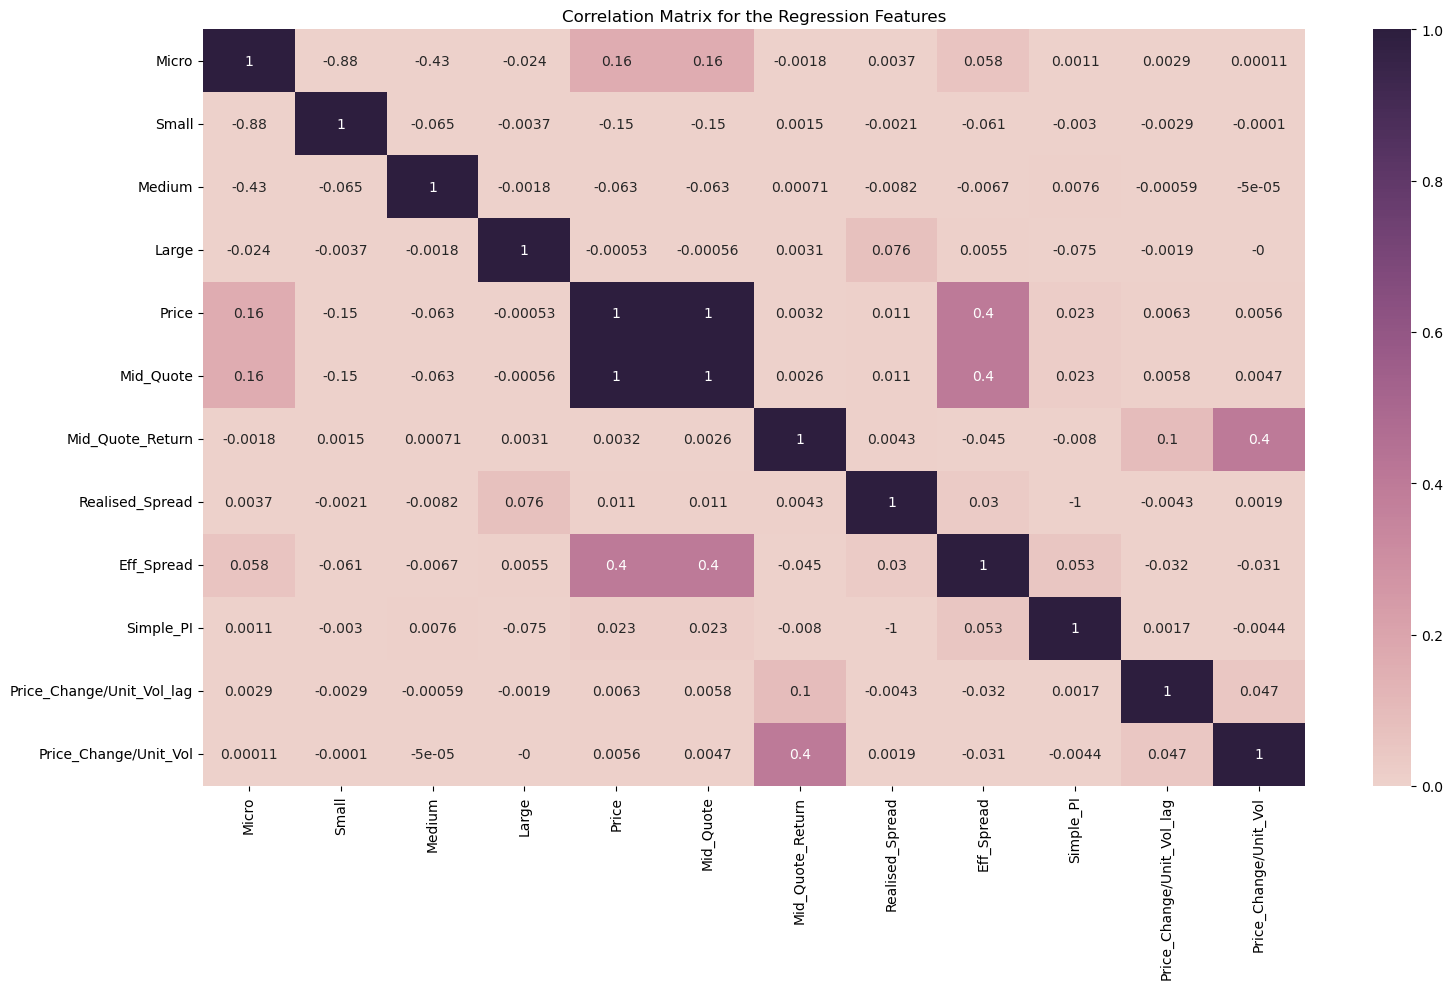

In [43]:
# Correlation Matrix

combined = pd.concat([X, y], axis = 1)
display(combined)
combined_corr = np.round(combined.corr(), 5)

plt.figure(figsize = (16,10))
sns.heatmap(combined_corr, vmin = 0., vmax = 1., cmap = sns.cubehelix_palette(as_cmap = True), annot = True)


plt.title('Correlation Matrix for the Regression Features', fontsize = 12)
plt.tight_layout()
plt.savefig('corr_mat.png', format = 'png')
plt.show()


## Regression 1: Following Journal, y = Price_Change/Unit_Vol

In [44]:
# Linear Regression

X = sm.add_constant(X)
linreg = sm.OLS(y, X)
results = linreg.fit()
print(results.summary())
print(results.t_test)

                              OLS Regression Results                             
Dep. Variable:     Price_Change/Unit_Vol   R-squared:                       0.208
Model:                               OLS   Adj. R-squared:                  0.208
Method:                    Least Squares   F-statistic:                     2586.
Date:                   Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                           23:07:58   Log-Likelihood:                -38571.
No. Observations:                  88670   AIC:                         7.716e+04
Df Residuals:                      88660   BIC:                         7.725e+04
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [45]:
display(results.params)
display(results.rsquared)

const                        -0.031040
Micro                         0.026491
Small                         0.026980
Medium                        0.025168
Large                        -0.109679
Price                         0.267813
Mid_Quote                    -0.267801
Mid_Quote_Return             40.878194
Realised_Spread               0.839332
Eff_Spread                    1.675761
Simple_PI                     0.836430
Price_Change/Unit_Vol_lag    -0.017860
dtype: float64

0.20793773751569355

## Regression 2: y = Simple_PI

In [ ]:
# Regression 2: y = Simple_PI
# One-hot Encoding
# Removing X_1_2 columns until R-squared makes sense 

X_1_2 = trade_5_s[['Price','Realised_Spread', 'Mid_Quote','Price_Change/Unit_Vol','Volume', 'Mid_Quote_Return']]
X_2_2 = pd.get_dummies(trade_5_s['Trade_Size_L1'])
y_2 = trade_5_s['Simple_PI']

X_2_2 = X_2_2.reindex(columns = ['Micro', 'Small', 'Medium', 'Large'])

X_2 = pd.concat([X_2_2, X_1_2], axis = 1)

print(f'X shape: {X_2.shape}, X columns = {X_2.columns}')
print(f'y shape: {y_2.shape}')

In [ ]:
# Linear Regression --> Micro coeff is still negative

X_2 = sm.add_constant(X_2)
linreg2 = sm.OLS(y_2, X_2)
results_2 = linreg2.fit()
print(results_2.summary())
print(results_2.t_test)

## OK -- Regression 3: Regression 2 Date Slicing 

In [46]:
# Slicing the Regression Samples --> up to 27 Jan (inclusive)
trade_5_s_27 = trade_5_s[trade_5_s.index.day <= 27]
trade_5_s_27.head(5)


,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,...,Mid_Quote,Prev_Mid_Quote,Next_Mid_Quote,Mid_Quote_Return,TickSB,Simple_PI,Eff_Spread,Realised_Spread,Price_Change/Unit_Vol,Price_Change/Unit_Vol_lag
Date-Time,,,,,,,,,,,,,,,,,,,,,
2021-01-04 09:30:05,Trade,19.10,85.0,19.04,2.0,19.10,1.0,^,2021-01-04,1.0,...,19.070,19.030,19.070,0.002102,1.0,0.000000,0.003146,0.003146,0.000471,0.000000
2021-01-04 09:30:10,Trade,19.10,85.0,19.04,2.0,19.10,1.0,^,2021-01-04,1.0,...,19.070,19.070,19.045,0.000000,1.0,-0.002622,0.003146,0.005768,0.000000,0.000471
2021-01-04 09:30:15,Trade,19.06,100.0,19.00,23.0,19.09,1.0,^,2021-01-04,1.0,...,19.045,19.070,19.045,-0.001311,1.0,0.000000,0.001575,0.001575,-0.000400,0.000000
2021-01-04 09:30:20,Trade,19.06,100.0,19.00,23.0,19.09,1.0,^,2021-01-04,1.0,...,19.045,19.045,19.045,0.000000,1.0,0.000000,0.001575,0.001575,0.000000,-0.000400
2021-01-04 09:30:25,Trade,19.06,100.0,19.00,23.0,19.09,1.0,^,2021-01-04,1.0,...,19.045,19.045,19.035,0.000000,1.0,-0.001050,0.001575,0.002625,0.000000,0.000000


In [47]:
# Regression 3: y = Simple_PI
# One-hot Encoding
# Removing X_1_2 columns until R-squared makes sense 

X_1_3 = trade_5_s_27[['Price','Realised_Spread', 'Mid_Quote','Price_Change/Unit_Vol','Volume', 'Mid_Quote_Return']]
X_2_3 = pd.get_dummies(trade_5_s_27['Trade_Size_L1'])
y_3 = trade_5_s_27['Simple_PI']

X_2_3 = X_2_3.reindex(columns = ['Micro', 'Small', 'Medium', 'Large'])

X_3 = pd.concat([X_2_3, X_1_3], axis = 1)

print(f'X shape: {X_3.shape}, X columns = {X_3.columns}')
print(f'y shape: {y_3.shape}')

X shape: (79322, 10), X columns = Index(['Micro', 'Small', 'Medium', 'Large', 'Price', 'Realised_Spread',
       'Mid_Quote', 'Price_Change/Unit_Vol', 'Volume', 'Mid_Quote_Return'],
      dtype='object')
y shape: (79322,)


In [48]:
# Linear Regression - 3

X_3 = sm.add_constant(X_3)
linreg3 = sm.OLS(y_3, X_3)
results_3 = linreg3.fit()
print(results_3.summary())
print(results_3.t_test)

                            OLS Regression Results                            
Dep. Variable:              Simple_PI   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 2.593e+06
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:08:12   Log-Likelihood:             3.9133e+05
No. Observations:               79322   AIC:                        -7.826e+05
Df Residuals:                   79312   BIC:                        -7.825e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00

## Regression 4: Regression 3 but y = PCUV

In [49]:
# Regression 4: y = Simple_PI
# One-hot Encoding


X_1_4 = trade_5_s_27[['Price','Realised_Spread', 'Mid_Quote','Simple_PI','Volume', 'Mid_Quote_Return']]
X_2_4 = pd.get_dummies(trade_5_s_27['Trade_Size_L1'])
y_4 = trade_5_s_27['Price_Change']

X_2_4 = X_2_4.reindex(columns = ['Micro', 'Small', 'Medium', 'Large'])

X_4 = pd.concat([X_2_4, X_1_4], axis = 1)

print(f'X shape: {X_4.shape}, X columns = {X_4.columns}')
print(f'y shape: {y_4.shape}')

X shape: (79322, 10), X columns = Index(['Micro', 'Small', 'Medium', 'Large', 'Price', 'Realised_Spread',
       'Mid_Quote', 'Simple_PI', 'Volume', 'Mid_Quote_Return'],
      dtype='object')
y shape: (79322,)


In [50]:
# Linear Regression - 4

X_4 = sm.add_constant(X_4)
linreg4 = sm.OLS(y_4, X_4)
results_4 = linreg4.fit()
print(results_4.summary())

                            OLS Regression Results                            
Dep. Variable:           Price_Change   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                 1.619e+04
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:08:19   Log-Likelihood:                -19291.
No. Observations:               79322   AIC:                         3.860e+04
Df Residuals:                   79312   BIC:                         3.869e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0232      0.032  

## Boxplot for Each L1 vs PI and PCUV

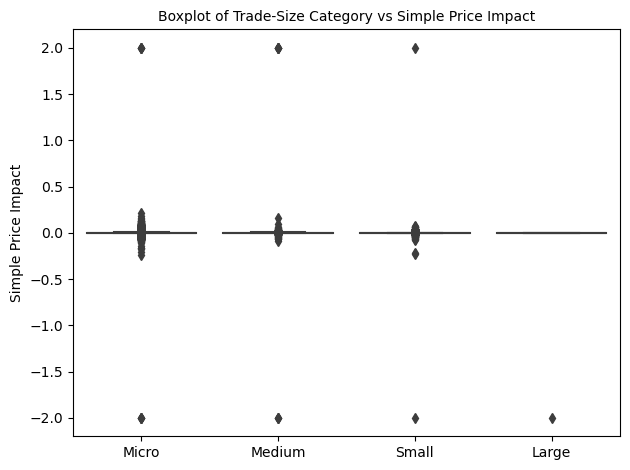

In [51]:
# for PI
plt.figure()
sns.boxplot(data = trade_5_s, y = 'Simple_PI', x = 'Trade_Size_L1')
plt.ylabel('Simple Price Impact')
plt.xlabel(None)
plt.title('Boxplot of Trade-Size Category vs Simple Price Impact', fontsize = 10)
plt.tight_layout()
plt.savefig('boxplot_pi.png')
plt.show()

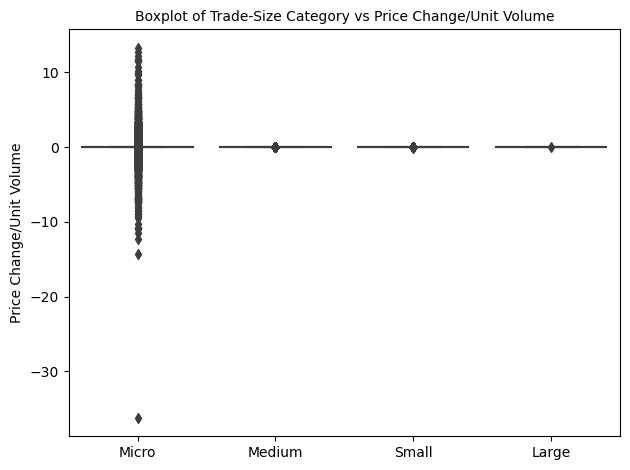

In [52]:
# for PCUV
plt.figure()
sns.boxplot(data = trade_5_s, y = 'Price_Change/Unit_Vol', x = 'Trade_Size_L1')
plt.title('Boxplot of Trade-Size Category vs Price Change/Unit Volume', fontsize = 10)
plt.ylabel('Price Change/Unit Volume')
plt.xlabel(None)
plt.tight_layout()
plt.savefig('boxplot_pcuv.png')
plt.show()

## Spearman Correlation Test for Regression X_2_3

In [53]:
X_2_3

,Micro,Small,Medium,Large
Date-Time,,,,
2021-01-04 09:30:05,1,0,0,0
2021-01-04 09:30:10,1,0,0,0
2021-01-04 09:30:15,1,0,0,0
2021-01-04 09:30:20,1,0,0,0
2021-01-04 09:30:25,1,0,0,0
...,...,...,...,...
2021-01-27 15:59:35,1,0,0,0
2021-01-27 15:59:40,1,0,0,0
2021-01-27 15:59:45,1,0,0,0


In [56]:
# Perform Spearman rank test to compare Trade_L1 with Price Impact and Price Change
pval_spear_pi = []
pval_spear_pcuv = []
cat = ['Micro', 'Small', 'Medium', 'Large']

for i in cat:
    coef_, p_ = spearmanr(X_2_3[i], trade_5_s_27['Simple_PI'])
    pval_spear_pi.append(p_)

    coef_pcuv, p_pcuv = spearmanr(X_2_3[i], trade_5_s_27['Price_Change/Unit_Vol'])
    pval_spear_pcuv.append(p_pcuv)

pval_spearman = pd.DataFrame({'p-value of Simple PI':pval_spear_pi, 'p-value of Price Change/Unit Vol':pval_spear_pcuv}, index = cat)
display(pval_spearman)
pval_spearman.to_csv('pval_spearman.csv')

,p-value of Simple PI,p-value of Price Change/Unit Vol
Micro,0.015652,0.048175
Small,0.034418,0.036356
Medium,0.262153,0.934703
Large,0.066395,0.215770


#  5-sec Dataframe Event Study

## Spread and Depth

In [ ]:
# Plot the realised spread as the %age of the effective spread

In [ ]:
trade_5_s['%Spread'] = np.round(trade_5_s['Realised_Spread']/trade_5_s['Eff_Spread'] * 100, 3)
display(trade_5_s.head(3))

In [ ]:
# Before Robinhood presses the brake
# Chart: see pg.6 of Week 2 Liquidity

In [ ]:
# Slicing the Regression Samples --> up to 27 Jan (inclusive)
set_upto_26 = trade_5_s[trade_5_s.index.day <= 26]
set_26 = trade_5_s[trade_5_s.index.day == 26]
set_27 = trade_5_s[trade_5_s.index.day == 27]
set_28 = trade_5_s[trade_5_s.index.day == 28]
set_29 = trade_5_s[trade_5_s.index.day == 29]

# Test
display(set_28.tail(2))
display(set_29.tail(2))

In [ ]:
# Buy Sell Tick




fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize = (12,12))
ax[0].plot(set_26[set_26['TickSB'] == 1]['Volume'], set_26[set_26['TickSB'] == 1]['Price'], 'g', label = 'Buy Side')
ax[0].plot(set_26[set_26['TickSB'] == -1]['Volume'], set_26[set_26['TickSB'] == -1]['Price'], 'b', label = 'Sell Side')

# ax0.grid()

# # Chart: Price
# ax1 = ax0.twinx()
# ax1.plot(trade.index, trade['Price'], label = 'Price')

# # Ticks, Title, Labels
# ax0.xaxis.set_major_locator(mdates.DayLocator())
# ax0.set_ylabel('Volume')
# ax1.set_ylabel('Price')
ax[0].legend()
fig.suptitle('Spread and Depth', fontsize = 14)

plt.show()


In [ ]:
# Plotting

dates_plot = [15, 25, 26, 27, 28, 29]

for d in dates_plot:
    trade_5_s_d = trade_5_s[trade_5_s.index.day == d]
    

    fig, (ax0, ax1) = plt.subplots(2, figsize = (15,8), sharex = True)

    trade_size_l1 = trade_5_s_d['Trade_Size_L1'].unique()

    for i, size in enumerate(trade_size_l1):
        subdata = trade_5_s_d[trade_5_s_d['Trade_Size_L1'] == size]
        ax0.plot(subdata.index, subdata['Simple_PI'], label = 'Simple_PI ' + size)
        ax1.plot(subdata.index, subdata['Eff_Spread'], linestyle = '--', label = 'Eff_Spread ' + size)

    plt.xticks(rotation = 90)

    # Ticks, Title, Labels
    ax0.xaxis.set_major_locator(mdates.HourLocator())
    ax0.legend()
    ax0.set_ylabel('Simple_PI')
    ax0.grid()

    ax1.legend()
    ax1.set_ylabel('Eff_Spread')
    ax1.grid()

    plt.suptitle(f'Simple Price Impact and Effective Spread on {d} Jan 2021')
    plt.show()

In [ ]:
# Intraday spreads: pg.17 of Week 2 Liquidity

fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize = (12,12))
ax[0].plot(set_26[set_26['Trade_Size_L1'] == 'Micro'].index, set_26[set_26['Trade_Size_L1'] == 'Micro']['%Spread'], 'g', label = 'Micro')

ax[1].plot(set_27[set_27['Trade_Size_L1'] == 'Micro'].index, set_27[set_27['Trade_Size_L1'] == 'Micro']['%Spread'], 'g', label = 'Micro')
# ax0.grid()

# # Chart: Price
# ax1 = ax0.twinx()
# ax1.plot(trade.index, trade['Price'], label = 'Price')

# # Ticks, Title, Labels
# ax0.xaxis.set_major_locator(mdates.DayLocator())
# ax0.set_ylabel('Volume')
# ax1.set_ylabel('Price')
ax[0].legend()
fig.suptitle('Intraday Spread', fontsize = 14)

plt.show()

# OIB-USD vs OIB-Trade Calc for the 1-min interval

In [ ]:
display(trade.head(5))


In [ ]:
# Run MQR PRCC and Simple PI Spread Function to get the TickSB
trade = mqr_prc_c(trade)
trade = simple_pi_spread(trade)



In [ ]:
trade

In [ ]:
# Regression R-2
# Expected Output: each day R2 & t-stat like in Chordia's paper


# Loop for every trading day

def reg_oib():
    '''
    Output: list of R-squared for each trading day
    '''
    dates = np.unique(trade.index.day)

    r_sq = []

    for date in dates:
        set_ = trade[trade.index.day == date]

        # Make list of index
        min_df_idx = min(set_.index)
        max_df_idx = max(set_.index)
        start_time = datetime(min_df_idx.year, min_df_idx.month, min_df_idx.day, min_df_idx.hour, min_df_idx.minute, 0)
        stop_time = datetime(max_df_idx.year, max_df_idx.month, max_df_idx.day, 16, 0, 0)
        timespan = pd.date_range(start = start_time, end = stop_time, freq = 'T')

        timesp_ = timespan[:-1]

        # Add empty lists of OIB$ and OIB#
        oib_usd_buy = []
        oib_usd_sell = []
        oib_usd_sum = []

        for i in range(len(timespan) - 1):

            buy_in = set_[((set_.index >= timespan[i]) & (set_.index < timespan[i+1])) & (set_['TickSB'] == 1)]['Total_USD'].sum()
            sell_in = set_[((set_.index >= timespan[i]) & (set_.index < timespan[i+1])) & (set_['TickSB'] == -1)]['Total_USD'].sum()
            totalu = set_[(set_.index >= timespan[i]) & (set_.index < timespan[i+1])]['Total_USD'].sum()

            oib_usd_buy.append(buy_in)
            oib_usd_sell.append(sell_in)
            oib_usd_sum.append(totalu)

        oib_df = pd.DataFrame({'Time':timesp_, 'Tot_Buy_USD':oib_usd_buy, 'Tot_Sell_USD':oib_usd_sell, 'Tot_USD':oib_usd_sum
                              })

        oib_df['OIB_USD'] = ((oib_df['Tot_Buy_USD'] - oib_df['Tot_Sell_USD'])/oib_df['Tot_USD']).fillna(0)

        oib_df['Lagged_OIB'] = oib_df['OIB_USD'].shift(1).fillna(0)

        # Dropping the 1st row because 0
        oib_df = oib_df.iloc[1:,:]

        # Grabbing the MQR from resampled 1-min due to same agg function --> last
        oib_df['Mid_Quote_Return'] = list(trade_1_min[(trade_1_min.index.day == min(oib_df['Time']).day)]['Mid_Quote_Return'])


        # display(oib_df)
        # display(oib_df[oib_df['OIB_USD'].isna()])

        # Regression
        y_oib_reg = oib_df['Mid_Quote_Return']
        X_oib_reg = oib_df['Lagged_OIB']
        X_oib_reg = sm.add_constant(X_oib_reg)
        oibreg = sm.OLS(y_oib_reg, X_oib_reg)
        results_ = oibreg.fit()

        r_sq.append(results_.rsquared)

    return r_sq


In [ ]:
y = reg_oib()

In [ ]:
# Plotting
dates = np.unique(trade.index.day)
plt.plot(dates, y)

# Not for Final Report

## Resample and Intervals 

## Regression and Robustness Check

In [ ]:

# create a heatmap
data = np.random.rand(10, 10)
heatmap = plt.pcolor(data, cmap='jet')

# add annotations to the heatmap
for i in range(len(data)):
    for j in range(len(data[0])):
        plt.text(j + 0.5, i + 0.5, '{:.2f}'.format(data[i][j]),
                 ha='center', va='center', fontsize=6)

# set the font size of the tick labels
plt.xticks(np.arange(0.5, len(data[0]), 1), fontsize=12)
plt.yticks(np.arange(0.5, len(data), 1), fontsize=12)

# add a colorbar
plt.colorbar(heatmap)

# show the plot
plt.show()


In [ ]:
# log_res = np.log10(to_log)
# print(log_res)

# check for NaN or infinity values
nan_mask = np.isnan(to_log)
inf_mask = np.isinf(to_log)

# print the index of the element that causes the error
if np.any(nan_mask):
    print("The array contains NaN values at index:", np.where(nan_mask))
if np.any(inf_mask):
    print("The array contains infinity values at index:", np.where(inf_mask))

npzer = np.where(to_log == 0)
print(npzer)


In [ ]:
# Group how many txn in 1-min interval

# Add new column of total dollar value
trade['Total_USD'] = trade['Price'] * trade['Volume']
set_25 = trade[trade.index.day == 25]

# set_4.to_csv('dataset/set_4.csv') --> to test the grouping in Excel  


In [ ]:
# Check length of index
# loop for every trading day
dates = np.unique(trade.index.day)

for date in dates:
    set_ = trade[trade.index.day == date]

    # Make list of index
    min_df_idx = min(set_.index)
    max_df_idx = max(set_.index)
    start_time = datetime(min_df_idx.year, min_df_idx.month, min_df_idx.day, min_df_idx.hour, min_df_idx.minute, 0)
    stop_time = datetime(max_df_idx.year, max_df_idx.month, max_df_idx.day, max_df_idx.hour, max_df_idx.minute, 0)
    timespan = pd.date_range(start = start_time, end = stop_time, freq = 'T')
    a = len(timespan)
    b = len(trade_1_min[trade_1_min.index.day == min(set_.index.day)].index)
    print(a-1,b,a-1 == b )


In [ ]:
# Make list of index
min_df_idx = min(set_25.index)
max_df_idx = max(set_25.index)

start_time = datetime(min_df_idx.year, min_df_idx.month, min_df_idx.day, min_df_idx.hour, min_df_idx.minute, 0)
stop_time = datetime(max_df_idx.year, max_df_idx.month, max_df_idx.day, 16, 0, 0)
timespan = pd.date_range(start = start_time, end = stop_time, freq = 'T')

timesp_ = timespan[:-1]

# Add empty lists of OIB$ and OIB#
oib_usd_buy = []
oib_usd_sell = []
oib_usd_sum = []

for i in range(len(timespan) - 1):
     
    buy_in = set_25[((set_25.index >= timespan[i]) & (set_25.index < timespan[i+1])) & (set_25['TickSB'] == 1)]['Total_USD'].sum()
    sell_in = set_25[((set_25.index >= timespan[i]) & (set_25.index < timespan[i+1])) & (set_25['TickSB'] == -1)]['Total_USD'].sum()
    totalu = set_25[(set_25.index >= timespan[i]) & (set_25.index < timespan[i+1])]['Total_USD'].sum()
    
    oib_usd_buy.append(buy_in)
    oib_usd_sell.append(sell_in)
    oib_usd_sum.append(totalu)
                          
oib_df = pd.DataFrame({'Time':timesp_, 'Tot_Buy_USD':oib_usd_buy, 'Tot_Sell_USD':oib_usd_sell, 'Tot_USD':oib_usd_sum
                      })

oib_df['OIB_USD'] = ((oib_df['Tot_Buy_USD'] - oib_df['Tot_Sell_USD'])/oib_df['Tot_USD']).fillna(0)

oib_df['Lagged_OIB'] = oib_df['OIB_USD'].shift(1).fillna(0)

# Dropping the 1st row because 0
oib_df = oib_df.iloc[1:,:]

# display(trade_1_min[trade_1_min.index.day == min(oib_df['Time']).day].index)
# display(oib_df['Time'])
# display(timespan)
# display(timesp_)

# Grabbing the MQR from resampled 1-min due to same agg function --> last
oib_df['Mid_Quote_Return'] = list(trade_1_min[trade_1_min.index.day == min(oib_df['Time']).day]['Mid_Quote_Return'])


display(oib_df)
# # display(oib_df[oib_df['OIB_USD'].isna()])

# # Regression
# y_oib_reg = oib_df['Mid_Quote_Return']
# X_oib_reg = oib_df['Lagged_OIB']
# X_oib_reg = sm.add_constant(X_oib_reg)
# oibreg = sm.OLS(y_oib_reg, X_oib_reg)
# results_ = oibreg.fit()
# coef_ = results_.params
# print(coef_[1])
# print(results_.rsquared)
# print(results_.summary())


    

In [ ]:
display(trade_1_min[trade_1_min.index.day == min(oib_df['Time']).day]['Mid_Quote_Return'])
min_df_idx = min(set_25.index)
max_df_idx = max(set_25.index)
display(max_df_idx.second)
display(len(oib_df.index))

In [ ]:
trade_1_min.info()

In [ ]:
# One-hot Encoding

X_1 = trade_1_min[['Volume']] 
X_2 = pd.get_dummies(trade_1_min['Trade_Size_L1'])

print(f'X_1 shape: {X_1.shape}, X_1 columns = {X_1.columns}')
print(f'X_2 shape: {X_2.shape}, X_2 columns = {X_2.columns}')
y = trade_1_min['Price_Change']
print(f'y shape: {y.shape}')

In [ ]:
display(X_2.head(5))

In [ ]:
X = pd.concat([X_2, X_1], axis = 1)
display(X)

In [ ]:
# Reindex the columns so Micro will be the 1st column: Mic - S - M - L
X = X.reindex(columns = ['Micro', 'Small', 'Medium', 'Large', 'Volume'])
display(X)

In [ ]:
# Correlation Matrix

combined = pd.concat([X, y], axis = 1)
display(combined)
combined_corr = combined.corr()
plt.figure(figsize = (10,6))
sns.heatmap(combined_corr, vmin = 0., vmax = 1., cmap = sns.cubehelix_palette(as_cmap = True), annot = True)
plt.title('Correlation Matrix for the Regression Features', fontsize = 14)
plt.show()


In [ ]:
# Linear Regression

X = sm.add_constant(X)
linreg = sm.OLS(y, X)
results = linreg.fit()
print(results.summary())
print(results.t_test)

In [ ]:
    # Add Subtotals
    
#     piv_cumprice = pd.concat([y.append(y.sum().rename((x, 'Total')))for x, y in piv_cumprice.groupby(level = 0)]).append(piv_cumprice.sum().rename(('Grand', 'Total')))

In [ ]:
# # Inner Join based on Trade L1 -- different size different list

# # Small
# index0_s = small_var_rat_1.index.names[0]
# index1_s = small_var_rat_1.index.names[1]
    # Add Subtotals
    
#     piv_cumprice = pd.concat([y.append(y.sum().rename((x, 'Total')))for x, y in piv_cumprice.groupby(level = 0)]).append(piv_cumprice.sum().rename(('Grand', 'Total')))
# s_var_rat_1_5 = pd.merge(small_var_rat_1, small_var_rat_5, on = [index0_s, index1_s], how = 'inner')
# # display(s_var_rat_1_5)

# # Medium
# index0_m = med_var_rat_1.index.names[0]
# index1_m = med_var_rat_5.index.names[1]

# m_var_rat_1_5 = pd.merge(med_var_rat_1, med_var_rat_5, on = [index0_m, index1_m], how = 'inner')
# # display(m_var_rat_1_5)


# # Rename Columns for Small
# s_var_rat_1_5 = s_var_rat_1_5.rename(columns = {'STD of MQR_x':'STD of MQR_1', 'Variance_x':'Var_of_MQR_1',
#                                                'STD of MQR_y':'STD of MQR_5', 'Variance_y':'Var_of_MQR_5'
#                                                })

# # Rename Columns for Medium
# m_var_rat_1_5 = m_var_rat_1_5.rename(columns = {'STD of MQR_x':'STD of MQR_1', 'Variance_x':'Var_of_MQR_1',
#                                                'STD of MQR_y':'STD of MQR_5', 'Variance_y':'Var_of_MQR_5'
#                                                })

# # Index for pivot Small

# list_s = list(s_var_rat_1_5['key_0'])
# index_date_s = []
# for i in list_s:
#     date_a = i[0]
#     index_date_s.append(date_a)


# # Index for pivot Medium

# list_m = list(m_var_rat_1_5['key_0'])
# index_date_m = []
# for i in list_m:
#     date_a = i[0]
#     index_date_m.append(date_a)
    
# # Add Variance Ratio Calculation
# s_var_rat_1_5['Var_Rat'] = np.abs((s_var_rat_1_5['Var_of_MQR_5']/(5 * s_var_rat_1_5['Var_of_MQR_1'])) - 1)
# m_var_rat_1_5['Var_Rat'] = np.abs((m_var_rat_1_5['Var_of_MQR_5']/(5 * m_var_rat_1_5['Var_of_MQR_1'])) - 1)

# display(s_var_rat_1_5)
# display(m_var_rat_1_5)

In [ ]:
# trade_1_min_micro = trade_1_min[trade_1_min['Trade_Size_L1'] == 'Small']
# trade_5_min_micro = trade_5_min[trade_5_min['Trade_Size_L1'] == 'Small']
# trade_1_min_small = trade_1_min[trade_1_min['Trade_Size_L1'] == 'Small']
# trade_5_min_small = trade_5_min[trade_5_min['Trade_Size_L1'] == 'Small']
# trade_1_min_med = trade_1_min[trade_1_min['Trade_Size_L1'] == 'Medium']
# trade_5_min_med = trade_5_min[trade_5_min['Trade_Size_L1'] == 'Medium']
# # trade_1_min_large = trade_1_min[trade_1_min['Trade_Size_L1'] == 'Large']
# # trade_5_min_large = trade_5_min[trade_5_min['Trade_Size_L1'] == 'Large']


# small_var_rat_1 = piv_varrat(trade_1_min_small)
# small_var_rat_5 = piv_varrat(trade_5_min_small)

# med_var_rat_1 = piv_varrat(trade_1_min_med)
# med_var_rat_5 = piv_varrat(trade_5_min_med)

# # Trade_5_min

# # large_var_rat_1 = piv_varrat(trade_1_min_large)
# # large_var_rat_5 = piv_varrat(trade_5_min_large)

# display(small_var_rat_1)
# display(small_var_rat_1.index.names[1])

In [ ]:
def resample_last(df, interval):
    '''
    This will not be used in the final analysis -- only for gauging the impact of different
    resample aggregation functions.
    default interpolation: linear
    df input = df name, e.g. trade
    interval input = as per requirement, in string, e.g. 'T', '5S', etc
    '''
    df_res = df.resample(interval).last().interpolate(method = 'linear')
    
    nan_price = df_res[df_res['Price'].isna()].index
    print('Original focus length before resampled:', len(df))
    print('Length after resampled:', len(df_res))
    print(f'Total Price NA: {len(nan_price)}')
    if len(nan_price) == 0:
        print('OK')
    display(df_res.describe())
    
    return df_res, interval

In [ ]:
def resample_mean(df, interval):
    '''
    This will not be used in the final analysis -- only for gauging the impact of different
    resample aggregation functions.
    default interpolation: linear
    df input = df name, e.g. trade
    interval input = as per requirement, in string, e.g. 'T', '5S', etc
    '''
    df_res = df.resample(interval).mean().interpolate(method = 'linear')
    
    nan_price = df_res[df_res['Price'].isna()].index
    print('Original focus length before resampled:', len(df))
    print('Length after resampled:', len(df_res))
    print(f'Total Price NA: {len(nan_price)}')
    if len(nan_price) == 0:
        print('OK')
    display(df_res.describe())
    
    return df_res, interval

In [ ]:
# Compare Resample Intervals and Technique
trade_min_last, int1 = resample_last(trade, 'T')
trade_h_last, int2 = resample_last(trade, 'H')
trade_min_mean, int3 = resample_mean(trade, 'T')
trade_h_mean, int4 = resample_mean(trade, 'H')

In [ ]:
#     fig, ax = plt.subplots(figsize = (10,4))

#     ax = sns.lineplot(x = df.index, y = 'Mid_Quote_Return', data = df, hue = 'Trade_Size_L1')

#     ax.set_xlabel('Date-Time')
#     ax.set_ylabel('Mid_Quote_Return')
#     ax.xaxis.set_major_locator(mdates.DayLocator())

#     ax.legend()

#     plt.title(f'Mid_Quote_Return of  Resampled Data , S-M-L Trade Sizes')
#     plt.grid()
#     plt.xticks(rotation = 90)
#     plt.show()

#     display(df['Trade_Size_L1'].value_counts())
#     display(df['Trade_Size_L2'].value_counts())

In [ ]:
# # Take the minute _ last

# # Create Pivot Table

# dates = trade_min_last.index.date
# var_rat = pd.pivot_table(trade_min_last, index = [dates,'Trade_Size_L1'],
#                              values = ['Mid_Quote_Return'], 
#                               aggfunc = sum, fill_value = 0, margins = False)

# display(trade_min_last.loc[trade_min_last['Trade_Size_L1'] == 'Large'])
# var_rat

# # Looks like the var_rat data calc has issue for std... try in csv

In [ ]:
# # Test diff aggregate function

# trade_min_test = trade.resample('T').agg({'Price' : 'mean', 'Volume' : 'last'})
# display(trade_min_test)
# display(trade_min_test.describe())

In [ ]:
# Fill the NaN value

# trade_min.loc[-1, 'Mid_Quote_Return'] = 0 --> doesn't work, add last row index -1
# trade_min.info()
# trade_min.drop(-1, inplace = True) --> must drop first
# trade_min['Mid_Quote_Return'].iloc[-1] --> works alone, but has to be paired with column index
# trade_min.loc[trade_min['Mid_Quote_Return'].iloc[-1],'Mid_Quote_Return']  = 0 --> doesn't work, only int

In [ ]:
# Sorting L0 cat custom

# import pandas as pd

# # create a sample DataFrame
# df = pd.DataFrame({'A': ['foo', 'foo', 'bar', 'bar', 'foo', 'foo'],
#                    'B': ['one', 'one', 'one', 'two', 'two', 'one'],
#                    'C': [1, 2, 3, 4, 5, 6],
#                    'D': [7, 8, 9, 10, 11, 12]})

# # create pivot table
# pivot_table = pd.pivot_table(df, values=['C', 'D'], index=['A', 'B'], aggfunc={'C': 'sum', 'D': 'mean'})

# # define custom order for first level index
# custom_order = ['bar', 'foo']

# # create a Categorical data type with custom order
# cat_dtype = pd.CategoricalDtype(categories=custom_order, ordered=True)

# # convert first level index to Categorical data type
# pivot_table.index = pivot_table.index.set_levels(pivot_table.index.levels[0].astype(cat_dtype), level=0)

# # sort pivot table by first level index
# pivot_table = pivot_table.sort_values(by=pivot_table.index.levels[0].name)

# print(pivot_table)


In [ ]:
# Apply function how

# df = pd.DataFrame({'Name': ['John', 'Sammy', 'Stephan', 'Joe', 'Emily', 'Tom'],
#                    'Gender': ['Male', 'Female', 'Male',
#                               'Female', 'Female', 'Male'],
#                    'Age': [45, 6, 4, 36, 12, 43]})
# print("Dataset")
# print(df)
# print("-"*40)
  
# # categorizing in age groups
# def age_bucket(age):
#     if age <= 18:
#         return "<18"
#     else:
#         return ">18"
  
# df['Age Group'] = df['Age'].apply(age_bucket)
  
# # calculating gender percentage
# gender = pd.DataFrame(df.Gender.value_counts(normalize=True)*100).reset_index()
# gender.columns = ['Gender', '%Gender']
# df = pd.merge(left=df, right=gender, how='inner', on=['Gender'])
  
# # creating pivot table
# table = pd.pivot_table(df, index=['Gender', '%Gender', 'Age Group'], 
#                        values=['Name'], aggfunc={'Name': 'count',})
  
# # display table
# print("Table")
# print(table)

In [ ]:
# Aggregate Function

# mean(): calculates the mean of each group
# sum(): calculates the sum of each group
# max(): returns the maximum value of each group
# min(): returns the minimum value of each group
# first(): returns the first value of each group
# last(): returns the last value of each group
# count(): returns the number of non-NA/null values in each group
# median(): returns the median of each group
# std(): calculates the standard deviation of each group
# var(): calculates the variance of each group

In [ ]:
#     for i, size in enumerate(trade_size_l1):
#         subdata = trade[trade['Trade_Size_L1'] == size]
#         ax0.plot(subdata.index, subdata['Mid_Quote_Return'], label = 'Mid-Quote Return' + size)
#         ax1.plot(subdata.index, subdata['Price_Change'], label = 'Price Change' + size, ls = '--')


In [ ]:
## Plot and Bins

In [ ]:
# # fig, ax = plt.subplots(figsize = (10,4))

# sns.lineplot(x = trade.index, y = 'Mid_Quote_Return', data = trade) #, hue = 'Trade_Size_L1' --> always slow idk why

# # ax.set_xlabel('Date-Time')
# # ax.set_ylabel('Mid_Quote_Return')
# # ax.xaxis.set_major_locator(mdates.DayLocator())

# # ax.legend()

# # plt.title(f'Mid_Quote_Return, S-M-L Trade Sizes')
# # plt.grid()
# # plt.xticks(rotation = 90)
# plt.show()

# display(trade['Trade_Size_L1'].value_counts())
# display(trade['Trade_Size_L2'].value_counts())
# trade_size_l1 = trade['Trade_Size_L1'].unique()

# fig, ax = plt.subplots(figsize = (12,6))

# ax0 = fig.add_subplot()
# plt.xticks(rotation = 90)

# ax1 = ax0.twinx()

# for i, size in enumerate(trade_size_l1):
#     subdata = trade[trade['Trade_Size_L1'] == size]
#     ax0.plot(subdata.index, subdata['Mid_Quote_Return'], label = 'Mid-Quote Return' + size)
#     ax1.plot(subdata.index, subdata['Price_Change'], label = 'Price Change' + size, ls = '--')
    
# ax0.grid()

# # Ticks, Title, Labels
# ax0.xaxis.set_major_locator(mdates.DayLocator())
# ax0.set_ylabel('Mid-Quote Return')
# ax1.set_ylabel('Price Change')
# fig.legend()
# fig.suptitle('Mid-Quote Return and Price Change by Size (not resampled)', fontsize = 14)

# plt.show()


In [ ]:
# Plotting

# interval = [int1, int2, int3, int4]
# aggr = ['last', 'last', 'mean', 'mean']
# for i in range(len(result)):
#     plot_(result[i], interval[i], aggr[i])



In [ ]:
min_sample = 19 * 6.5 * 60 # --> 19 days of sample, 6.5 hr trading window, 60 min
print(min_sample)
min_5sample = 19 * 6.5 * 12 # --> 5min interval
print(min_5sample)